In [1]:
%load_ext rpy2.ipython
%load_ext autotime
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import sys
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation
from pprint import pprint

R[write to console]: Installing package into ‘/home/stephan/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Reinstalling childesr version 0.2.1


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/childesr_0.2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 22865 bytes (22 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

time: 9.11 s (started: 2022-02-21 16:56:52 -08:00)


In [2]:
%%R
# load R dependencies
library('plyr')
library('tidyr')
library('plotROC')
library('pROC')

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var




time: 157 ms (started: 2022-02-21 16:57:01 -08:00)


In [3]:
sys.path.append('../../')
from src.utils import sample_models_across_time, load_models, hyperparameter_utils, configuration
config = configuration.Config()

time: 134 ms (started: 2022-02-21 16:57:01 -08:00)


In [4]:
%%R
filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}

sem <- function(x) sd(x)/sqrt(length(x))

time: 4.81 ms (started: 2022-02-21 16:57:01 -08:00)


# Load Scores and move to R

In [5]:
import imp
imp.reload(sample_models_across_time)
imp.reload(load_models)
imp.reload(hyperparameter_utils)
config = configuration.Config()
config.childes_model_args

[['all', 'all'], ['age', 'young'], ['age', 'old'], ['switchboard', 'all']]

time: 17.3 ms (started: 2022-02-21 16:57:01 -08:00)


In [6]:
levdist_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('levdist'))
# Remove 0.5 and 4.0 because they are sparse.
levdist_scores_across_time = levdist_scores_across_time[~levdist_scores_across_time.age.isin({0.5, 4.0})]
levdist_scores_across_time['likelihood_type'] = 'Levenshtein Distance'

time: 2.2 s (started: 2022-02-21 16:57:01 -08:00)


In [7]:
np.unique(levdist_scores_across_time.split)

array(['age', 'all', 'switchboard'], dtype=object)

time: 611 ms (started: 2022-02-21 16:57:03 -08:00)


In [8]:
levdist_scores_across_time.loc[levdist_scores_across_time.split == 'switchboard', 'model'] = [
    x.replace('CHILDES', 'Switchboard') for x in  levdist_scores_across_time.loc[levdist_scores_across_time.split \
== 'switchboard'].model]

time: 563 ms (started: 2022-02-21 16:57:04 -08:00)


In [9]:
np.unique(levdist_scores_across_time.model)

array(['Adult BERT without tags, , +-20 utts context',
       'Adult BERT without tags, , same utt only',
       'CHILDES BERT with tags, , +-20 utts context',
       'CHILDES BERT with tags, , same utt only',
       'CHILDES BERT with tags, older children, +-20 utts context',
       'CHILDES BERT with tags, older children, same utt only',
       'CHILDES BERT with tags, younger children, +-20 utts context',
       'CHILDES BERT with tags, younger children, same utt only',
       'CHILDES BERT without tags, , +-20 utts context',
       'CHILDES BERT without tags, , same utt only',
       'CHILDES BERT without tags, older children, +-20 utts context',
       'CHILDES BERT without tags, older children, same utt only',
       'CHILDES BERT without tags, younger children, +-20 utts context',
       'CHILDES BERT without tags, younger children, same utt only',
       'CHILDES Unigram', 'Flat Unigram',
       'Switchboard BERT without tags, , +-20 utts context',
       'Switchboard BERT with

time: 648 ms (started: 2022-02-21 16:57:04 -08:00)


In [10]:
wfst_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('wfst'))
# Remove 0.5 and 4.0 because they are sparse.
wfst_scores_across_time = wfst_scores_across_time[~wfst_scores_across_time.age.isin({0.5, 4.0})]
wfst_scores_across_time['likelihood_type'] = 'WFST'

time: 2.13 s (started: 2022-02-21 16:57:05 -08:00)


In [11]:
wfst_scores_across_time.loc[wfst_scores_across_time.split == 'switchboard', 'model'] = [
    x.replace('CHILDES', 'Switchboard') for x in  wfst_scores_across_time.loc[wfst_scores_across_time.split \
== 'switchboard'].model]

time: 551 ms (started: 2022-02-21 16:57:07 -08:00)


In [12]:
np.unique(wfst_scores_across_time.model)

array(['Adult BERT without tags, , +-20 utts context',
       'Adult BERT without tags, , same utt only',
       'CHILDES BERT with tags, , +-20 utts context',
       'CHILDES BERT with tags, , same utt only',
       'CHILDES BERT with tags, older children, +-20 utts context',
       'CHILDES BERT with tags, older children, same utt only',
       'CHILDES BERT with tags, younger children, +-20 utts context',
       'CHILDES BERT with tags, younger children, same utt only',
       'CHILDES BERT without tags, , +-20 utts context',
       'CHILDES BERT without tags, , same utt only',
       'CHILDES BERT without tags, older children, +-20 utts context',
       'CHILDES BERT without tags, older children, same utt only',
       'CHILDES BERT without tags, younger children, +-20 utts context',
       'CHILDES BERT without tags, younger children, same utt only',
       'CHILDES Unigram', 'Flat Unigram',
       'Switchboard BERT without tags, , +-20 utts context',
       'Switchboard BERT with

time: 663 ms (started: 2022-02-21 16:57:08 -08:00)


In [13]:
wfst_scores_across_time.iloc[0]

prior_rank                                                              NaN
prior_prob                                                              NaN
entropy                                                             7.96437
num_tokens_in_context                                                     3
bert_token_id                                                        246234
set                                                                 failure
mask_position                                                           NaN
token                                                                   NaN
utterance_id                                                            NaN
posterior_entropy                                                   3.11747
posterior_rank                                                          NaN
prior_entropy                                                       5.52048
position_in_mask                                                        NaN
kl_flat_to_p

time: 4.9 ms (started: 2022-02-21 16:57:08 -08:00)


In [14]:
raw_scores_across_time = pd.concat([levdist_scores_across_time, wfst_scores_across_time])

time: 1.2 s (started: 2022-02-21 16:57:08 -08:00)


In [15]:
all_args = load_models.gen_all_model_args()

beta_set = {}
lambda_set = {}
for arg_set in all_args:
    
    model_title = load_models.gen_model_title(*arg_set)
    
    this_beta = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'beta')
    this_lambda = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'lambda')

    # correct the model name, but only after loading the hyperparameter file
    if arg_set[0] == 'switchboard':
        corrected_model_title = model_title.replace('CHILDES','Switchboard')
    else:
        corrected_model_title = model_title
        
    
    beta_set[corrected_model_title] = round(this_beta, 3)
    lambda_set[corrected_model_title] = round(this_lambda, 3)
    
pprint(beta_set)
pprint(lambda_set)

{'Adult BERT without tags, , +-20 utts context': 3.5,
 'Adult BERT without tags, , same utt only': 4.2,
 'CHILDES BERT with tags, , +-20 utts context': 3.2,
 'CHILDES BERT with tags, , same utt only': 3.2,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, older children, same utt only': 3.5,
 'CHILDES BERT with tags, younger children, +-20 utts context': 3.0,
 'CHILDES BERT with tags, younger children, same utt only': 3.1,
 'CHILDES BERT without tags, , +-20 utts context': 3.2,
 'CHILDES BERT without tags, , same utt only': 3.3,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.5,
 'CHILDES BERT without tags, older children, same utt only': 3.6,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.2,
 'CHILDES BERT without tags, younger children, same utt only': 3.2,
 'CHILDES unigram without tags, , same utt only': 3.5,
 'Flat prior without tags, , same utt only': 3.7,
 'Switchboard BERT without tags, , +-20 u

In [16]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}

tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

scores_across_time = raw_scores_across_time.copy()


time: 531 ms (started: 2022-02-21 16:57:10 -08:00)


In [17]:
# this takes forever -- moving things into R is expensive
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability','prior_entropy',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance','likelihood_type','prior_rank','posterior_rank']]
%R -i scores_across_time_short 

time: 2min 11s (started: 2022-02-21 16:57:10 -08:00)


In [18]:
%%R
levels(factor(scores_across_time_short$model))

 [1] "Adult BERT without tags, , +-20 utts context"                  
 [2] "Adult BERT without tags, , same utt only"                      
 [3] "CHILDES BERT with tags, , +-20 utts context"                   
 [4] "CHILDES BERT with tags, , same utt only"                       
 [5] "CHILDES BERT with tags, older children, +-20 utts context"     
 [6] "CHILDES BERT with tags, older children, same utt only"         
 [7] "CHILDES BERT with tags, younger children, +-20 utts context"   
 [8] "CHILDES BERT with tags, younger children, same utt only"       
 [9] "CHILDES BERT without tags, , +-20 utts context"                
[10] "CHILDES BERT without tags, , same utt only"                    
[11] "CHILDES BERT without tags, older children, +-20 utts context"  
[12] "CHILDES BERT without tags, older children, same utt only"      
[13] "CHILDES BERT without tags, younger children, +-20 utts context"
[14] "CHILDES BERT without tags, younger children, same utt only"    
[15] "CHILDES Unigra

In [19]:
%%R
# rename the models

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram",
                 "Switchboard BERT without tags, , +-20 utts context",
                 "Switchboard BERT without tags, , same utt only"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior",
                     "Switchboard BERT without tags, , +-20 utts context" = "Switchboard+Context",
                     "Switchboard BERT without tags, , same utt only" = "Switchboard+OneUtt"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)
successes_across_time = subset(scores_across_time_short, set == 'success')

time: 56.4 s (started: 2022-02-21 16:59:22 -08:00)


In [20]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

time: 5.07 ms (started: 2022-02-21 17:00:19 -08:00)


In [21]:
%%R
overview_set = c(
    'CDL+Context+Tags',
    'BERT+Context',
    'CDL+OneUtt+Tags',
    'BERT+OneUtt',
    'Switchboard+Context',
    'Switchboard+OneUtt',
    'CHILDES 1gram',
    'UniformPrior'
)

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

time: 14.7 ms (started: 2022-02-21 17:00:19 -08:00)


# Verify Sample Size

In [22]:
%%R
successes_and_failures_per_time = aggregate(bert_token_id ~ set + age, subset(scores_across_time_short, likelihood_type == 'WFST' & model == 'UniformPrior'), 
          length)
print(successes_and_failures_per_time)

print(sum(successes_and_failures_per_time$bert_token_id))

       set age bert_token_id
1  failure 1.0          1521
2  success 1.0          2412
3  failure 1.5          1890
4  success 1.5          5499
5  failure 2.0          1412
6  success 2.0         10877
7  failure 2.5          1149
8  success 2.5         13980
9  failure 3.0           699
10 success 3.0          8517
11 failure 3.5            85
12 success 3.5          2708
[1] 50749
time: 300 ms (started: 2022-02-21 17:00:19 -08:00)


# Analysis 1: Is the child's vocalization intelligible? 

## ROC for Whether a Word Was Found

In [23]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 1583860  243216
time: 1.15 s (started: 2022-02-21 17:00:19 -08:00)


In [24]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "Switchboard+OneUtt"       "Switchboard+Context"     
[17] "UniformPrior"             "CHILDES 1gram"           
time: 88 ms (started: 2022-02-21 17:00:20 -08:00)


## WFST


In [213]:
%%R
auc_by_model = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_wfst = auc(roc1)))}))

scores_across_time_short_wfst = merge(subset(scores_across_time_short, likelihood_type == 'WFST') , auc_by_model)



R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 39.4 s (started: 2022-02-22 05:15:46 -08:00)


In [214]:
%%R

# get rid of tags in the designation
scores_across_time_overview_set = filter_model_subset(scores_across_time_short_wfst, overview_set)
scores_across_time_overview_set$model_shortname = gsub('\\+Tags','', scores_across_time_overview_set$model)

scores_across_time_overview_set$model_shortname_with_wfst_auc = paste0(scores_across_time_overview_set$model_shortname,' (AUC = ',round(scores_across_time_overview_set$auc_wfst, 3),')')

time: 3.73 s (started: 2022-02-22 05:16:26 -08:00)


In [215]:
%%R 
# get the scores associated with each model + a  
names_per_model = aggregate(model_shortname_with_wfst_auc ~ model_shortname, scores_across_time_overview_set, unique)
scores_per_model_wfst = aggregate(auc_wfst ~ model_shortname,scores_across_time_overview_set, unique)
scores_per_model_wfst = merge(names_per_model, scores_per_model_wfst)
scores_per_model_wfst = scores_per_model_wfst[order(scores_per_model_wfst$auc_wfst, decreasing=T),]
print(scores_per_model_wfst)

scores_across_time_overview_set$model_shortname_with_wfst_auc = factor(as.character(scores_across_time_overview_set$model_shortname_with_wfst_auc), levels = as.character(scores_per_model_wfst$model_shortname_with_wfst_auc))

      model_shortname     model_shortname_with_wfst_auc  auc_wfst
3         CDL+Context         CDL+Context (AUC = 0.915) 0.9147973
1        BERT+Context        BERT+Context (AUC = 0.903) 0.9025264
6 Switchboard+Context Switchboard+Context (AUC = 0.899) 0.8994706
4          CDL+OneUtt          CDL+OneUtt (AUC = 0.893) 0.8926886
7  Switchboard+OneUtt  Switchboard+OneUtt (AUC = 0.875) 0.8752968
2         BERT+OneUtt         BERT+OneUtt (AUC = 0.846) 0.8456843
5       CHILDES 1gram       CHILDES 1gram (AUC = 0.755) 0.7554012
8        UniformPrior        UniformPrior (AUC = 0.628) 0.6275376
time: 1.81 s (started: 2022-02-22 05:16:29 -08:00)


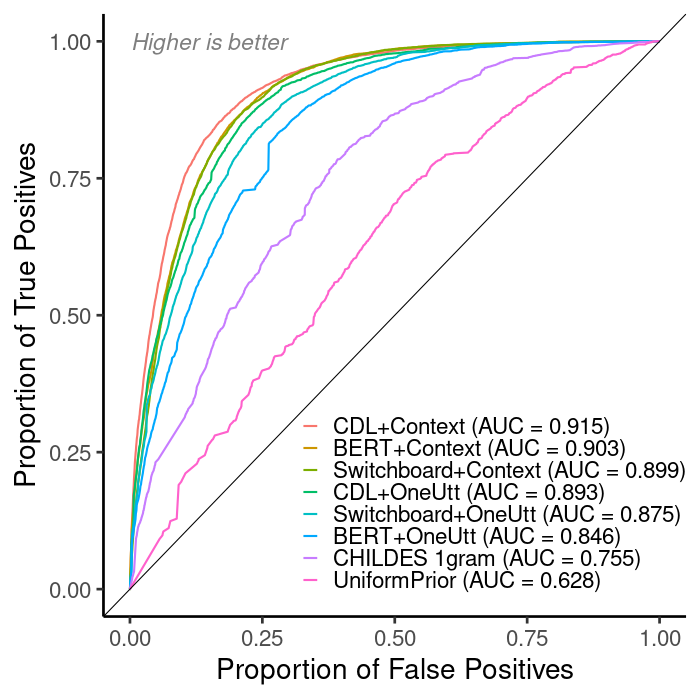

time: 2.38 s (started: 2022-02-22 07:57:25 -08:00)


In [251]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('../../output/figures/roc_wfst.pdf', height=10, width=10)    

### Set Color Standards for All Plots

In [196]:
%%R
g <- ggplot_build(p1)
colors_for_8_plots = unique(g$data[[1]]$colour)
reorder = c(1,3,2,4,5,6,7,8)
colors_for_8_plots = colors_for_8_plots[reorder]
print(colors_for_8_plots)

[1] "#F8766D" "#7CAE00" "#CD9600" "#00BE67" "#00BFC4" "#00A9FF" "#C77CFF"
[8] "#FF61CC"
time: 1.72 s (started: 2022-02-22 05:06:38 -08:00)


In [197]:
%%R
models_for_8_plots = scores_per_model$model_shortname[reorder]
print(as.character(models_for_8_plots))
shapes_for_8_plots = c(19, 17,  7, 18, 4, 15, 3, 1)

[1] "CDL+Context"         "Switchboard+Context" "BERT+Context"       
[4] "CDL+OneUtt"          "Switchboard+OneUtt"  "BERT+OneUtt"        
[7] "CHILDES 1gram"       "UniformPrior"       
time: 15.6 ms (started: 2022-02-22 05:06:39 -08:00)


In [ ]:
scores_across_time_short_lev$model_shortname= gsub('\\+Tags','',scores_across_time_short_lev$model)
scores_across_time_short_lev$model_shortname = factor(scores_across_time_short_lev$model_shortname, levels = models_for_8_plots)

In [ ]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
#ggsave('../../output/figures/roc_wfst.pdf', height=10, width=10)    

In [ ]:
%%R -h 700 -w 700
p1 = ggplot(scores_across_time_overview_set, 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname_with_wfst_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('../../output/figures/roc_wfst.pdf', height=10, width=10)    

## Levenshtein Distance

In [205]:
%%R
auc_by_model_lev = do.call('rbind', lapply(unique(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance')$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc_levdist = auc(roc1)))}))

scores_across_time_short_lev = merge(subset(scores_across_time_short, likelihood_type == 'Levenshtein Distance') , auc_by_model_lev)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

time: 40 s (started: 2022-02-22 05:13:05 -08:00)


In [206]:
%%R
scores_across_time_short_lev$model_with_levdist_auc = paste0(scores_across_time_short_lev$model,' (AUC = ',
round(scores_across_time_short_lev$auc_levdist, 3),')')

time: 7.87 s (started: 2022-02-22 05:13:45 -08:00)


In [207]:
%%R
# sort the levels by the scores
names_per_model = aggregate(model_with_levdist_auc ~ model, scores_across_time_short_lev, unique)
scores_per_model_lev = aggregate(auc_levdist ~ model, scores_across_time_short_lev, unique)
scores_per_model_lev = merge(names_per_model, scores_per_model_lev)
scores_per_model_lev = scores_per_model_lev[order(scores_per_model_lev$auc_levdist, decreasing=T),]
print(scores_per_model_lev)
scores_across_time_short_lev$model_with_levdist_auc = factor(as.character(scores_across_time_short_lev$model_with_levdist_auc), 
                                                             levels = as.character(scores_per_model_lev$model_with_levdist_auc))

                      model                 model_with_levdist_auc auc_levdist
6    CDL+Older+Context+Tags    CDL+Older+Context+Tags (AUC = 0.87)   0.8703459
5         CDL+Older+Context         CDL+Older+Context (AUC = 0.87)   0.8697567
4          CDL+Context+Tags         CDL+Context+Tags (AUC = 0.869)   0.8688764
3               CDL+Context              CDL+Context (AUC = 0.866)   0.8659712
11      CDL+Younger+Context      CDL+Younger+Context (AUC = 0.861)   0.8605074
1              BERT+Context             BERT+Context (AUC = 0.858)   0.8575618
12 CDL+Younger+Context+Tags CDL+Younger+Context+Tags (AUC = 0.857)   0.8566561
16      Switchboard+Context      Switchboard+Context (AUC = 0.841)   0.8413605
9                CDL+OneUtt               CDL+OneUtt (AUC = 0.835)   0.8347963
7          CDL+Older+OneUtt         CDL+Older+OneUtt (AUC = 0.834)   0.8337872
10          CDL+OneUtt+Tags          CDL+OneUtt+Tags (AUC = 0.829)   0.8290755
13       CDL+Younger+OneUtt       CDL+Younger+OneUtt

In [247]:
%%R
# fix the model titles and the line colors
scores_across_time_short_lev$model_shortname= gsub('\\+Tags','',scores_across_time_short_lev$model)
scores_across_time_short_lev$model_shortname = factor(scores_across_time_short_lev$model_shortname, levels = models_for_8_plots)


scores_across_time_short_wfst$model_shortname= gsub('\\+Tags','',scores_across_time_short_wfst$model)
scores_across_time_short_wfst$model_shortname = factor(scores_across_time_short_wfst$model_shortname, levels = models_for_8_plots)

time: 2.66 s (started: 2022-02-22 07:46:57 -08:00)


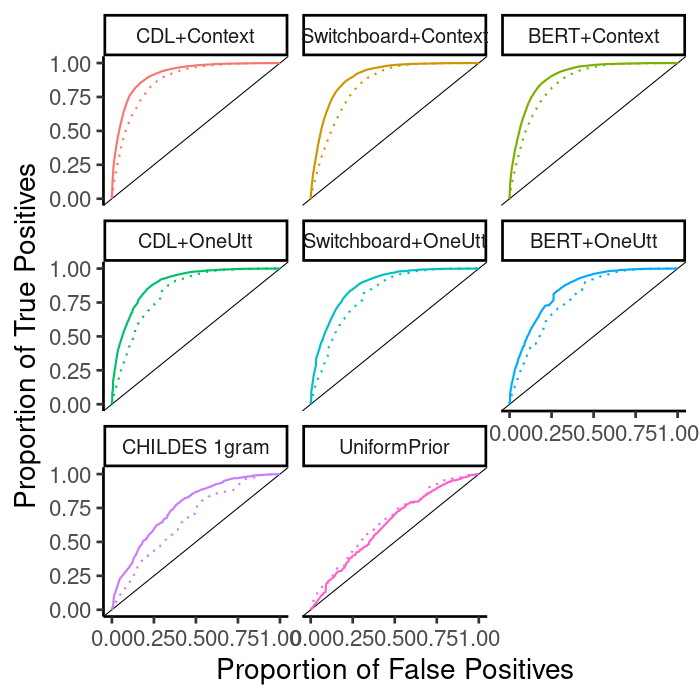

time: 7.02 s (started: 2022-02-22 07:47:02 -08:00)


In [248]:
%%R -h 700 -w 700
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname), linetype = 'dashed'
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0, linetype="dotted") + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position="none")  + geom_abline(intercept=0, slope=1
) + facet_wrap(~model_shortname) + geom_roc(data=filter_model_subset(scores_across_time_short_wfst,
overview_set), aes(d=set_binarized, 
m=posterior_entropy, color=model_shortname), n.cuts=0) + theme(strip.text.x = element_text(size = 20))
ggsave('../../output/figures/roc_levdist.pdf', height=10, width=10)   + scale_color_manual(
        values=colors_for_8_plots)  
print(p1)

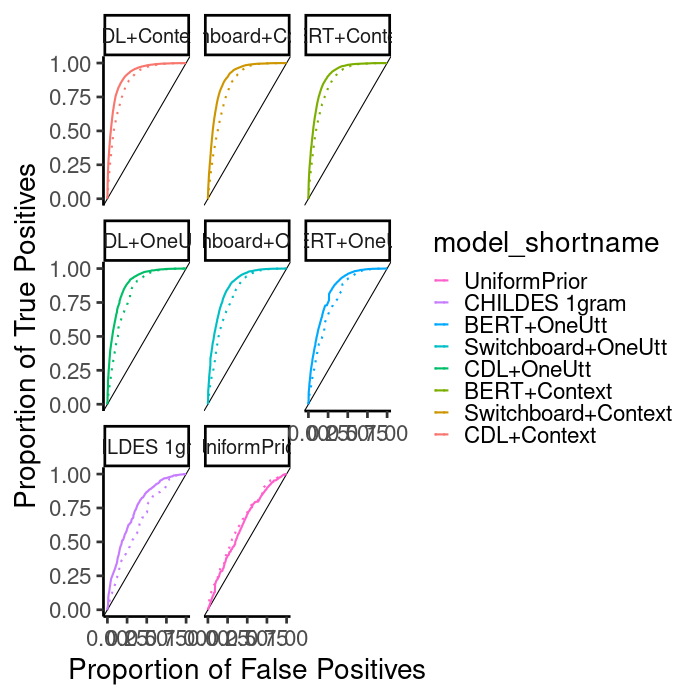

time: 2.9 s (started: 2022-03-02 08:16:04 -08:00)


In [512]:
%%R -h 700 -w 700
p1 = ggplot(filter_model_subset(scores_across_time_short_lev, overview_set), 
       aes(d=set_binarized, m=posterior_entropy, color=model_shortname), linetype = 'dashed'
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0, linetype="dotted") + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + geom_abline(intercept=0, slope=1
) + facet_wrap(~model_shortname) + geom_roc(data=filter_model_subset(scores_across_time_short_wfst,
overview_set), aes(d=set_binarized,  m=posterior_entropy, color=model_shortname), n.cuts=0) + theme(strip.text.x = element_text(size = 20)
) +  guides(color = guide_legend(reverse=TRUE))
print(p1)

## Visualization of Successes and Failures

In [37]:
%%R
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "Switchboard+OneUtt"       "Switchboard+Context"     
[17] "UniformPrior"             "CHILDES 1gram"           
time: 81.3 ms (started: 2022-02-21 17:03:34 -08:00)


In [38]:
%%R
names(scores_across_time_short)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "set_binarized"        
time: 33.4 ms (started: 2022-02-21 17:03:34 -08:00)


In [39]:
%%R
index_cols = c('bert_token_id', 'set')
selected_cols = c('posterior_entropy', 'posterior_probability', 'posterior_rank', 'prior_entropy', 'prior_probability', 'prior_rank')
best_model = subset(scores_across_time_short, model == "CDL+Context+Tags" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(best_model) = c(index_cols, paste0('bert_', selected_cols))
base_model = subset(scores_across_time_short, model == "UniformPrior" & likelihood_type == 'WFST')[,c(index_cols,selected_cols)]
names(base_model) = c(index_cols, paste0('uniform_', selected_cols))
model_scores_merged = merge(best_model, base_model)

time: 1.42 s (started: 2022-02-21 17:03:34 -08:00)


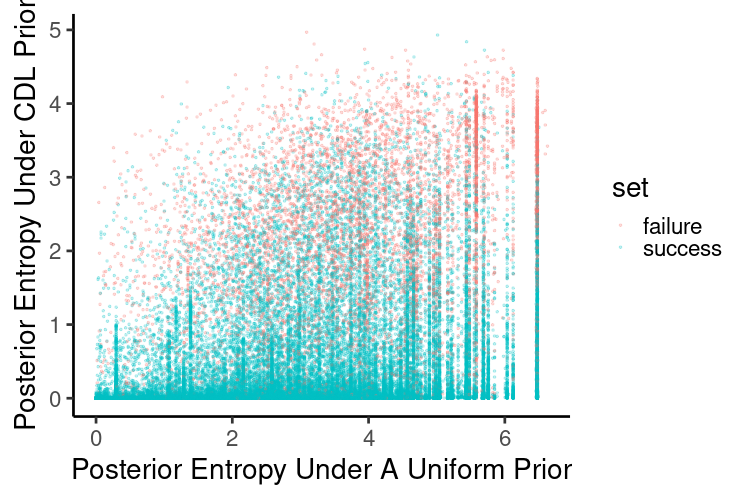

time: 909 ms (started: 2022-02-21 17:03:35 -08:00)


In [40]:
%%R -w 750 -h 500 
ggplot(model_scores_merged) + geom_point(aes(x=uniform_posterior_entropy, y=bert_posterior_entropy, color=set), alpha=.25, size=1
) + theme_classic(base_size=28) + xlab('Posterior Entropy Under A Uniform Prior') + ylab('Posterior Entropy Under CDL Prior')

## Statistical Tests for Difference in ROC curves

### Pairwise comparison of WFST ROC curves

In [41]:
%%R

models = unique(subset(scores_across_time_short, likelihood_type == 'WFST')$model)
models[1]
roc_tests = mat.or.vec(length(models), length(models))

time: 241 ms (started: 2022-02-21 17:03:36 -08:00)


In [42]:
%%R



#precompute ROCs
rocs = list()
for (model_name in overview_set){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'WFST')
    rocs[[model_name]] = roc(one_model$set_binarized, one_model$posterior_entropy)
}

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



time: 1.46 s (started: 2022-02-21 17:03:36 -08:00)


In [43]:
%%R

roc_ps = mat.or.vec(length(overview_set), length(overview_set))
roc_stats = mat.or.vec(length(overview_set), length(overview_set))



for (i in c(1:length(overview_set))){
    for (j in c(1:i)){
        roc1 = rocs[[overview_set[i]]]
        roc2 = rocs[[overview_set[j]]]
        rtest = roc.test(roc1, roc2, method="delong")
        roc_ps[i,j] = round(rtest$p.value, 3)        
        roc_stats [i,j] = abs(round(rtest$statistic, 3))        
    }
}    


roc_ps = data.frame(roc_ps)
names(roc_ps) = overview_set
colnames(roc_ps) = overview_set


roc_stats = data.frame(roc_stats)
names(roc_stats) = overview_set
colnames(roc_stats) = overview_set

time: 481 ms (started: 2022-02-21 17:03:38 -08:00)


In [44]:
%%R

roc_stats

  CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt Switchboard+Context
1            0.000        0.000           0.000       0.000               0.000
2            8.301        0.000           0.000       0.000               0.000
3           15.025        6.010           0.000       0.000               0.000
4           31.540       32.451          23.642       0.000               0.000
5            6.547        1.295           2.754      19.668               0.000
6           15.517       10.627           6.543      10.170              14.220
7           48.414       44.971          40.973      25.227              43.198
8           75.968       72.882          68.918      53.852              71.092
  Switchboard+OneUtt CHILDES 1gram UniformPrior
1              0.000         0.000            0
2              0.000         0.000            0
3              0.000         0.000            0
4              0.000         0.000            0
5              0.000         0.000      

In [45]:
%%R
roc_ps

  CDL+Context+Tags BERT+Context CDL+OneUtt+Tags BERT+OneUtt Switchboard+Context
1                1        0.000           0.000           0                   0
2                0        1.000           0.000           0                   0
3                0        0.000           1.000           0                   0
4                0        0.000           0.000           1                   0
5                0        0.195           0.006           0                   1
6                0        0.000           0.000           0                   0
7                0        0.000           0.000           0                   0
8                0        0.000           0.000           0                   0
  Switchboard+OneUtt CHILDES 1gram UniformPrior
1                  0             0            0
2                  0             0            0
3                  0             0            0
4                  0             0            0
5                  0             0      

In [46]:
%%R
roc_stats[5,2] = NA
print(min(roc_stats[roc_stats > 0], na.rm=T))
print(max(roc_stats[roc_stats > 0], na.rm=T))

[1] 2.754
[1] 75.968
time: 11.5 ms (started: 2022-02-21 17:03:39 -08:00)


In [47]:
%%R
roc_ps[5,2] = NA
print(min(roc_ps[roc_ps < 1], na.rm=T))
print(max(roc_ps[roc_ps < 1], na.rm=T))

[1] 0
[1] 0.006
time: 11 ms (started: 2022-02-21 17:03:39 -08:00)


### Paired Comparison of Likelihoods Within Model

In [235]:
%%R
#precompute ROCs
levdist_rocs = list()
for (model_name in overview_set){
    one_model = subset(scores_across_time_short, model == model_name & likelihood_type == 'Levenshtein Distance')
    levdist_rocs[[model_name]] = roc(one_model$set_binarized, one_model$posterior_entropy)
}

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



time: 1.71 s (started: 2022-02-22 07:24:56 -08:00)


In [237]:
%%R
paired_comparison =  do.call('rbind', lapply(overview_set, function(model_name){    
    roc1 = rocs[[model_name]]
    roc2 = levdist_rocs[[model_name]]
    rtest = roc.test(roc1, roc2, method="delong")    

    prob = round(rtest$p.value, 3)        
    stat = abs(round(rtest$statistic, 3))    
    return(data.frame(model_name, prob, stat))        
}))

paired_comparison

            model_name prob   stat
D     CDL+Context+Tags    0 17.874
D1        BERT+Context    0 17.241
D2     CDL+OneUtt+Tags    0 22.399
D3         BERT+OneUtt    0 18.116
D4 Switchboard+Context    0 21.951
D5  Switchboard+OneUtt    0 20.979
D6       CHILDES 1gram    0 21.340
D7        UniformPrior    0  5.373
time: 256 ms (started: 2022-02-22 07:30:31 -08:00)


In [239]:
%%R
print(auc(rocs[['UniformPrior']]))
print(auc(levdist_rocs[['UniformPrior']]))

Area under the curve: 0.6275
Area under the curve: 0.6535
time: 24.4 ms (started: 2022-02-22 07:38:08 -08:00)


# Analysis 2: Do the models find the same words as adults?

In [253]:
%%R
unique(successes_across_time$token)[1:100]

  [1] "snake"     "water"     "spilled"   "done"      "now"       "a"        
  [7] "bed"       "toast"     "daddy"     "no"        "yes"       "up"       
 [13] "here"      "that"      "eight"     "clip"      "does"      "fit"      
 [19] "leopard"   "and"       "coat"      "puppy"     "book"      "hot"      
 [25] "bye"       "okay"      "all"       "wife"      "mommy"     "read"     
 [31] "little"    "boy"       "one"       "smoke"     "three"     "cookie"   
 [37] "see"       "yeah"      "cut"       "it"        "try"       "two"      
 [43] "moon"      "he"        "like"      "the"       "yoga"      "class"    
 [49] "wee"       "rock"      "uncle"     "dean"      "airplane"  "at"       
 [55] "swim"      "hat"       "sally"     "she"       "passes"    "where"    
 [61] "go"        "owls"      "this"      "um"        "football"  "what"     
 [67] "happened"  "to"        "baby"      "ah"        "big"       "sees"     
 [73] "is"        "mammal"    "hi"        "bear"      "guy"     

## Prior and Posterior Table

In [48]:
%%R
unique(successes_across_time$likelihood_type)

[1] "Levenshtein Distance" "WFST"                
time: 71 ms (started: 2022-02-21 17:03:39 -08:00)


### WFST

In [333]:
%%R
# note that we don't need to separate the prior computations by the likelihood type-- it's the prior!

prior_probs = aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})
posterior_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){mean(-1 * log(x, base = 2))})
prior_probs = merge(prior_probs, posterior_probs)
    

subset(prior_probs, model %in% overview_set)

                 model prior_probability posterior_probability
1         BERT+Context          4.620648             1.0644113
2          BERT+OneUtt          7.338912             1.8815163
4     CDL+Context+Tags          3.330677             0.6464443
10     CDL+OneUtt+Tags          5.066861             1.0963438
15       CHILDES 1gram          8.786068             2.2773164
16 Switchboard+Context          4.171558             0.8905783
17  Switchboard+OneUtt          6.518799             1.5814190
18        UniformPrior         12.965243             4.6082285
time: 1e+03 ms (started: 2022-03-01 15:55:51 -08:00)


In [334]:
%%R
posterior_probs_sd = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){sem(-1 * log(x, base = 2))})
names(posterior_probs_sd) = c('model', 'posterior_probability_sem')


prior_probs_sem = aggregate(prior_probability ~ model, subset(successes_across_time, likelihood_type == 'WFST'), function(x){sem(-1 * log(x, base = 2))})
names(prior_probs_sem) = c('model', 'prior_probability_sem')

prior_probs = merge(merge(prior_probs, posterior_probs_sd), prior_probs_sem)
prior_probs = prior_probs[order(prior_probs$prior_probability),]
prior_probs$prior_low = prior_probs$prior_probability - prior_probs$prior_probability_sem
prior_probs$prior_high = prior_probs$prior_probability + prior_probs$prior_probability_sem
prior_probs$posterior_low = prior_probs$posterior_probability - prior_probs$posterior_probability_sem
prior_probs$posterior_high = prior_probs$posterior_probability + prior_probs$posterior_probability_sem
prior_probs


                      model prior_probability posterior_probability
6    CDL+Older+Context+Tags          3.308740             0.6545136
4          CDL+Context+Tags          3.330677             0.6464443
3               CDL+Context          3.395102             0.6548287
5         CDL+Older+Context          3.407456             0.6686642
12 CDL+Younger+Context+Tags          3.539305             0.6973982
11      CDL+Younger+Context          3.560870             0.6932930
16      Switchboard+Context          4.171558             0.8905783
1              BERT+Context          4.620648             1.0644113
8     CDL+Older+OneUtt+Tags          5.066277             1.1066951
10          CDL+OneUtt+Tags          5.066861             1.0963438
7          CDL+Older+OneUtt          5.246146             1.1554517
9                CDL+OneUtt          5.263628             1.1482564
14  CDL+Younger+OneUtt+Tags          5.400214             1.1886152
13       CDL+Younger+OneUtt          5.472719   

In [305]:
%%R
# try bootstrapping it instead
library(boot)

fc <- function(x,i ){
	return(mean(x[i]))
}

x = rnorm(1000)
print(x[1:10])
boot.ci(boot(x, fc, R=1000), type="basic")$basic[,4:5]

# get the 95% ci

 [1]  0.01923721  0.18464579 -0.51724665  0.27256884 -0.46226331  0.41737784
 [7]  1.92384887  0.51070347  0.43058695 -0.16527150
[1] -0.06499991  0.05757719
time: 140 ms (started: 2022-03-01 15:38:30 -08:00)


In [321]:
%%R
library('parallel')
fc <- function(x,i ){
	return(mean(x[i]))
}

wfst_df = subset(successes_across_time, likelihood_type == 'WFST')
df_split = split(wfst_df, wfst_df$model) 
results = do.call('rbind', mclapply(df_split, function(df){
    x = -1 * log(df$prior_probability, base = 2)
    ci = boot.ci(boot(x, fc, R=10), type="basic")$basic
    return(data.frame(model = unique(df$model), low=ci[4], high=ci[5]))
}, mc.cores=24))



time: 34.5 s (started: 2022-03-01 15:50:20 -08:00)


In [323]:
results

                                            model
CDL+Context+Tags                 CDL+Context+Tags
CDL+Context                           CDL+Context
CDL+OneUtt+Tags                   CDL+OneUtt+Tags
CDL+OneUtt                             CDL+OneUtt
BERT+Context                         BERT+Context
BERT+OneUtt                           BERT+OneUtt
CDL+Older+Context+Tags     CDL+Older+Context+Tags
CDL+Older+Context               CDL+Older+Context
CDL+Older+OneUtt                 CDL+Older+OneUtt
CDL+Older+OneUtt+Tags       CDL+Older+OneUtt+Tags
CDL+Younger+Context+Tags CDL+Younger+Context+Tags
CDL+Younger+Context           CDL+Younger+Context
CDL+Younger+OneUtt+Tags   CDL+Younger+OneUtt+Tags
CDL+Younger+OneUtt             CDL+Younger+OneUtt
CHILDES 1gram                       CHILDES 1gram
UniformPrior                                 <NA>
Switchboard+Context           Switchboard+Context
Switchboard+OneUtt             Switchboard+OneUtt
                                                  

In [552]:
%%R
posterior_mean_rankings = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean_posterior_rank = mean(x)})
names(posterior_mean_rankings) = c('model', 'likelihood_type', 'mean_posterior_rank')

prior_mean_rankings = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){mean_prior_rank = mean(x)})
names(prior_mean_rankings) = c('model', 'likelihood_type', 'mean_prior_rank')


posterior_median_rankings = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){median_posterior_rank = median(x)+1})
names(posterior_median_rankings) = c('model', 'likelihood_type', 'median_posterior_rank')
# 0-indexed coming from Python, so incrementing by one

prior_median_rankings = aggregate(prior_rank ~ model  + likelihood_type, successes_across_time, function(x){median_prior_rank = median(x)+1})
names(prior_median_rankings) = c('model', 'likelihood_type', 'median_prior_rank')
# 0-indexed coming from Pythong, so incrementing by one

rankings = merge(prior_mean_rankings, posterior_mean_rankings, by=c('model', 'likelihood_type'))

rankings = merge(rankings, posterior_median_rankings, by=c('model', 'likelihood_type'))
rankings = merge(rankings, prior_median_rankings, by=c('model', 'likelihood_type'))



rankings = rankings[order(rankings$mean_prior_rank),]
subset(rankings, model %in% overview_set)

                 model      likelihood_type mean_prior_rank mean_posterior_rank
7     CDL+Context+Tags Levenshtein Distance        50.48621            8.150160
8     CDL+Context+Tags                 WFST        50.48621            2.457164
31 Switchboard+Context Levenshtein Distance       116.21612           15.217828
32 Switchboard+Context                 WFST       116.21612            4.846891
19     CDL+OneUtt+Tags Levenshtein Distance       125.69245           25.514991
20     CDL+OneUtt+Tags                 WFST       125.69245            6.965835
1         BERT+Context Levenshtein Distance       140.76924           19.104858
2         BERT+Context                 WFST       140.76924            6.176142
29       CHILDES 1gram Levenshtein Distance       313.72412           51.082354
30       CHILDES 1gram                 WFST       313.72412           14.542632
33  Switchboard+OneUtt Levenshtein Distance       375.80207           45.056837
34  Switchboard+OneUtt                 W

In [553]:
%%R
for_table = subset(merge(prior_probs, rankings, all.x=T), model %in% overview_set)
for_table
for_table$prior_probability = round(for_table$prior_probability, 2)
for_table$posterior_probability = round(for_table$posterior_probability, 2)
for_table$mean_prior_rank = round(for_table$mean_prior_rank, 2)
for_table$mean_posterior_rank = round(for_table$mean_posterior_rank, 2)
#for_table = for_table[order(for_table$prior_probability),]

table_for_writing =  subset(for_table, likelihood_type == "WFST")[,c('model','prior_probability','mean_prior_rank','posterior_probability','mean_posterior_rank')]
names(table_for_writing) = c('Model', 'Prior Surprisal (bits)', 'Mean Prior Rank', 'Posterior Surprisal (bits)', 'Mean Posterior Rank')
table_for_writing

                 Model Prior Surprisal (bits) Mean Prior Rank
2         BERT+Context                   4.62          140.77
4          BERT+OneUtt                   7.34          495.14
8     CDL+Context+Tags                   3.33           50.49
20     CDL+OneUtt+Tags                   5.07          125.69
30       CHILDES 1gram                   8.79          313.72
32 Switchboard+Context                   4.17          116.22
34  Switchboard+OneUtt                   6.52          375.80
36        UniformPrior                  12.97         3998.00
   Posterior Surprisal (bits) Mean Posterior Rank
2                        1.06                6.18
4                        1.88               17.88
8                        0.65                2.46
20                       1.10                6.97
30                       2.28               14.54
32                       0.89                4.85
34                       1.58               14.67
36                       4.61             

In [554]:
%%R
write.csv(for_table, '../../output/csv/surprisal_table.csv', row.names=F)

time: 11.8 ms (started: 2022-03-04 07:35:51 -08:00)


In [555]:
%%R
nrow(for_table)

[1] 16
time: 13.2 ms (started: 2022-03-04 07:35:52 -08:00)


In [556]:
%%R
as.character(subset(for_table, likelihood_type == 'WFST')$model)

[1] "BERT+Context"        "BERT+OneUtt"         "CDL+Context+Tags"   
[4] "CDL+OneUtt+Tags"     "CHILDES 1gram"       "Switchboard+Context"
[7] "Switchboard+OneUtt"  "UniformPrior"       
time: 30.1 ms (started: 2022-03-04 07:35:52 -08:00)


R[write to console]: Saving 6.67 x 6.67 in image



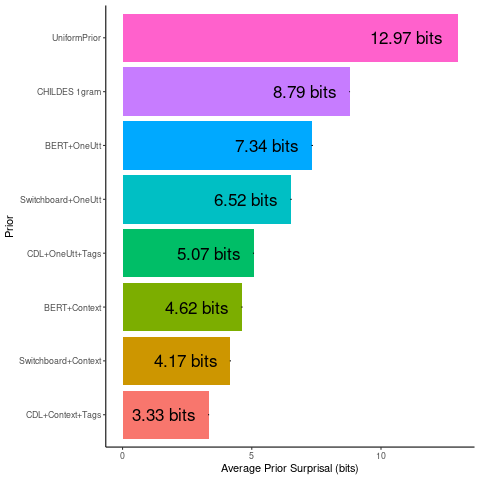

time: 373 ms (started: 2022-03-04 07:35:53 -08:00)


In [557]:
%%R
table_for_ordering = subset(for_table, likelihood_type == 'WFST')
table_for_ordering = table_for_ordering[order(table_for_ordering$prior_probability),]

for_table$model  = factor(for_table$model, levels = table_for_ordering$model)
for_table$prior_probability_bits = paste(for_table$prior_probability, 'bits')

p1 =  ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=prior_probability, fill=model), stat="identity"
) + coord_flip() + ylab('Average Prior Surprisal (bits)') + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_errorbar(aes(x=model, ymin=prior_low, ymax = prior_high), width = 0
)+  geom_text(aes(x=model, y=prior_probability, label=prior_probability_bits), hjust=1.2, size=6
) 
print(p1)

ggsave('../../output/figures/prior_bar_chart.pdf')

R[write to console]: Saving 6.67 x 6.67 in image



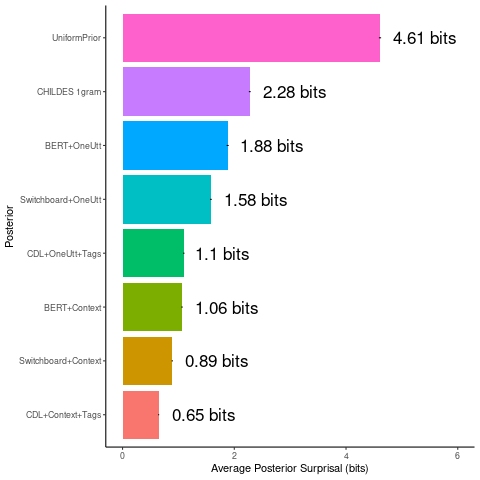

time: 304 ms (started: 2022-03-04 07:35:54 -08:00)


In [558]:
%%R
for_table$posterior_probability_bits = paste(for_table$posterior_probability, 'bits')

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=posterior_probability, fill=model), stat="identity"
)  + ylab('Average Posterior Surprisal (bits)') + xlab('Posterior') + theme_classic() +
theme(legend.position="none") + geom_errorbar(aes(x=model, ymin=posterior_low, ymax = posterior_high), width = 0
)+  geom_text(aes(x=model, y=posterior_probability, label=posterior_probability_bits), hjust=-.2, size=6
)  + coord_flip(ylim=c(0, 6))

print(p1)
ggsave('../../output/figures/posterior_bar_chart.pdf')

R[write to console]: Saving 6.67 x 6.67 in image



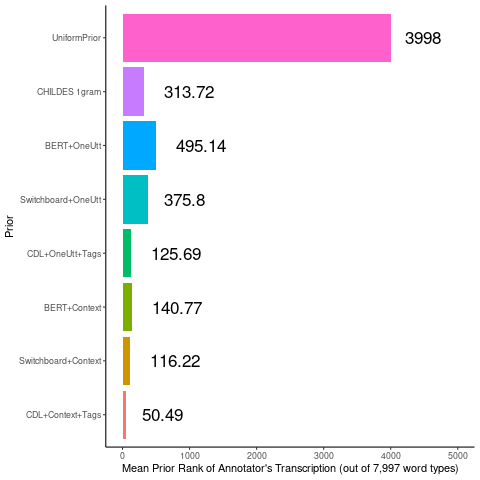

time: 281 ms (started: 2022-03-08 03:55:56 -08:00)


In [569]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=mean_prior_rank, fill=model), stat="identity"
)  + ylab("Mean Prior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=mean_prior_rank, label=mean_prior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 5000)) 
print(p1)
ggsave('../../output/figures/prior_rank.pdf')


R[write to console]: Saving 6.67 x 6.67 in image



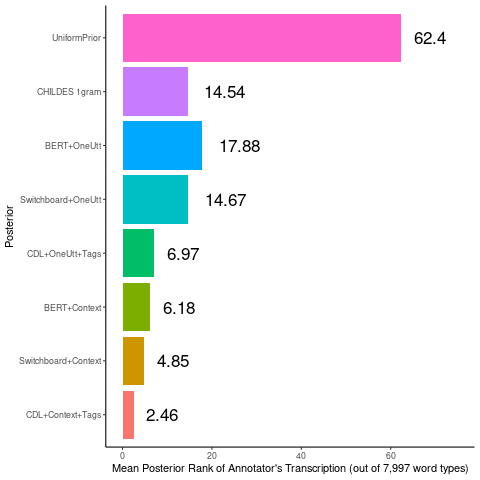

time: 256 ms (started: 2022-03-08 03:55:58 -08:00)


In [570]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=mean_posterior_rank, fill=model), stat="identity"
)  + ylab("Mean Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Posterior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=mean_posterior_rank, label=mean_posterior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 75)) 
print(p1)
ggsave('../../output/figures/posterior_rank.pdf')

### Compare Likelihood Functions

R[write to console]: Saving 6.67 x 6.67 in image



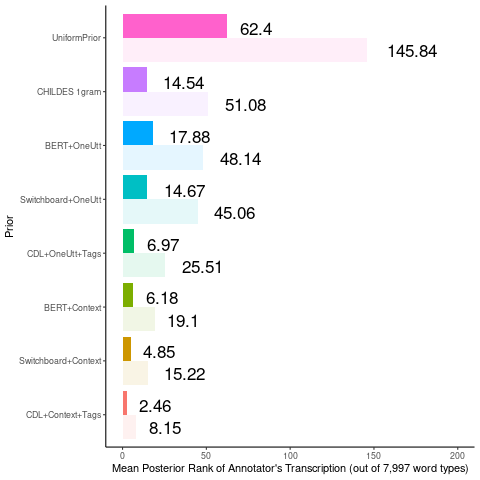

time: 325 ms (started: 2022-03-04 07:35:59 -08:00)


In [561]:
%%R
library(ggpattern)

p1 = ggplot(for_table) + geom_bar(aes(x=model, y=mean_posterior_rank, fill=model, alpha=likelihood_type), stat="identity", position="dodge"
)  + ylab("Mean Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(data=subset(for_table, likelihood_type =='WFST'), aes(x=model, y=mean_posterior_rank, 
label=mean_posterior_rank), hjust=-.4, size=6, vjust=-.2,                                          
position = "dodge") + geom_text(data=subset(for_table, likelihood_type =='Levenshtein Distance'), aes(x=model, y=mean_posterior_rank, 
label=mean_posterior_rank), hjust=-.4, size=6, vjust=1.5,                                          
position = "dodge")  + coord_flip(ylim =c(0, 200)) 
print(p1)
ggsave('../../output/figures/posterior_rank_by_likelihood.pdf')

### Median Ranks

In [562]:
%%R
# aggregate number by rank by mode
number_by_rank_by_model = aggregate(posterior_probability ~ posterior_rank + model,
    subset(successes_across_time, likelihood_type == 'WFST') , length) 
names(number_by_rank_by_model) = c('posterior_rank' , 'model', 'number_items')

number_by_rank_by_model = subset(number_by_rank_by_model, model %in% overview_set)
number_by_rank_by_model$model  = factor(number_by_rank_by_model$model, levels = table_for_ordering$model)


time: 1.14 s (started: 2022-03-04 07:36:02 -08:00)


R[write to console]: Saving 6.67 x 6.67 in image



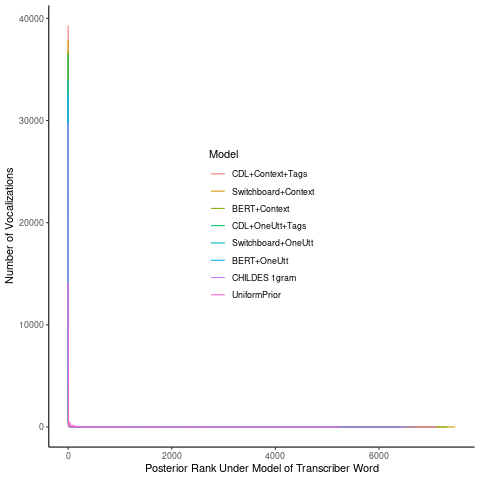

time: 431 ms (started: 2022-03-04 07:42:55 -08:00)


In [567]:
%%R
p1 = ggplot(number_by_rank_by_model) + geom_line(aes(
 x=posterior_rank, y = number_items, color=model))  + theme_classic(
) + ylab('Number of Vocalizations') + xlab('Posterior Rank Under Model of Transcriber Word'
) + theme(legend.position = c(.5, .5)) + labs(color='Model')
ggsave('../../output/figures/density_posterior_rank_full.pdf')
print(p1)

R[write to console]: Saving 6.67 x 6.67 in image



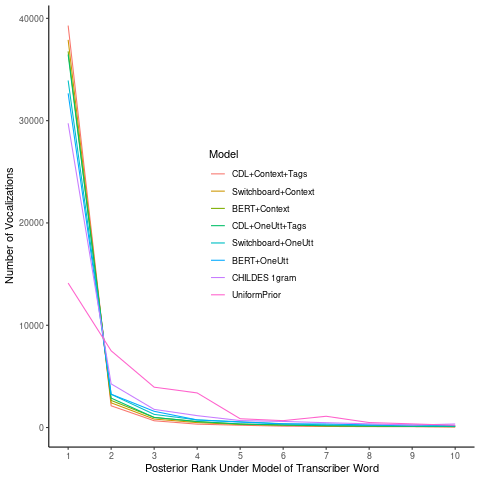

time: 423 ms (started: 2022-03-08 04:01:21 -08:00)


In [574]:
%%R
p1 = ggplot(subset(number_by_rank_by_model,
posterior_rank <= 9)) + geom_line(aes(
 x=posterior_rank+1, y = number_items, color=model))  + theme_classic(
) + ylab('Number of Vocalizations') + xlab('Posterior Rank Under Model of Transcriber Word'
) + theme(legend.position = c(.5, .5)) + labs(color='Model') + scale_x_continuous(
    breaks = c(1:10), labels = c(1:10))
ggsave('../../output/figures/density_posterior_rank_10.pdf')
print(p1)

R[write to console]: Saving 6.67 x 6.67 in image



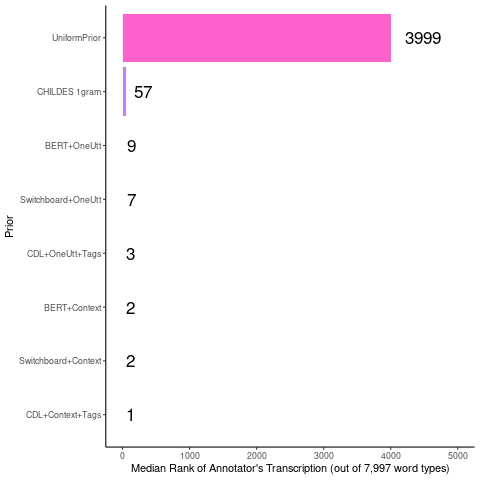

time: 267 ms (started: 2022-03-04 07:36:52 -08:00)


In [565]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=median_prior_rank, fill=model), stat="identity"
)  + ylab("Median Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=median_prior_rank, label=median_prior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 5000)) 
print(p1)
ggsave('../../output/figures/median_prior_rank.pdf')



R[write to console]: Saving 6.67 x 6.67 in image



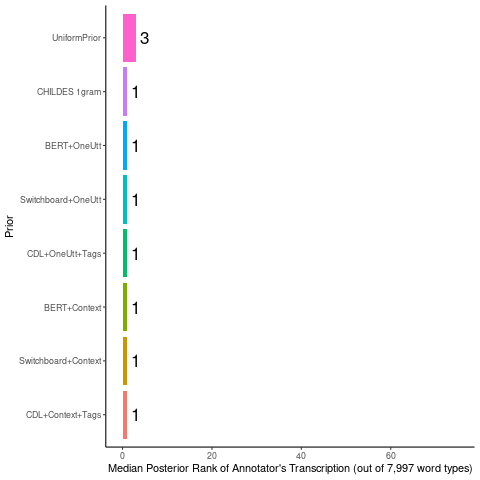

time: 401 ms (started: 2022-03-04 07:38:16 -08:00)


In [566]:
%%R

p1 = ggplot(subset(for_table, likelihood_type == 'WFST')) + geom_bar(aes(x=model, y=median_posterior_rank, fill=model), stat="identity"
)  + ylab("Median Posterior Rank of Annotator's Transcription (out of 7,997 word types)") + xlab('Prior') + theme_classic() +
theme(legend.position="none") + geom_text(aes(x=model, y=median_posterior_rank, label=median_posterior_rank), hjust=-.4, size=6
)  + coord_flip(ylim =c(0, 75)) 
print(p1)
ggsave('../../output/figures/median_posterior_rank.pdf')

### Levenshtein Distance (Posteriors Only)

In [150]:
%%R
lev_probs = aggregate(posterior_probability ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean(-1 * log(x, base = 2))})
lev_rankings = aggregate(posterior_rank ~ model, subset(successes_across_time, likelihood_type == 'Levenshtein Distance'), function(x){mean_posterior_rank = mean(x)})
names(lev_rankings) = c('model', 'mean_posterior_rank')
lev_for_table = subset(merge(lev_probs, lev_rankings, all.x=T), model %in% overview_set)
lev_for_table[order(lev_for_table$posterior_probability),]

                 model posterior_probability mean_posterior_rank
4     CDL+Context+Tags              1.183490             8.15016
16 Switchboard+Context              1.596443            15.21783
1         BERT+Context              1.719009            19.10486
10     CDL+OneUtt+Tags              1.965825            25.51499
17  Switchboard+OneUtt              2.624089            45.05684
2          BERT+OneUtt              2.884170            48.14005
15       CHILDES 1gram              3.841817            51.08235
18        UniformPrior              5.059256           145.84482
time: 897 ms (started: 2022-02-22 04:24:18 -08:00)


In [151]:
%%R
lev_for_table$posterior_probability = round(lev_for_table$posterior_probability, 2)
lev_for_table$mean_posterior_rank = round(lev_for_table$mean_posterior_rank, 2)
lev_for_table = lev_for_table[,c('model','posterior_probability','mean_posterior_rank')]
lev_for_table =  lev_for_table[order(lev_for_table$posterior_probability),]
names(lev_for_table) = c('Model', 'Posterior Surprisal (bits)', 'Mean Posterior Rank')
lev_for_table

                 Model Posterior Surprisal (bits) Mean Posterior Rank
4     CDL+Context+Tags                       1.18                8.15
16 Switchboard+Context                       1.60               15.22
1         BERT+Context                       1.72               19.10
10     CDL+OneUtt+Tags                       1.97               25.51
17  Switchboard+OneUtt                       2.62               45.06
2          BERT+OneUtt                       2.88               48.14
15       CHILDES 1gram                       3.84               51.08
18        UniformPrior                       5.06              145.84
time: 39.2 ms (started: 2022-02-22 04:24:19 -08:00)


In [55]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id','likelihood_type')], model, prior_probability)
successes_across_time_wide = subset(successes_across_time_wide, likelihood_type == 'WFST')
head(successes_across_time_wide)

   bert_token_id likelihood_type CDL+Context+Tags  CDL+Context CDL+OneUtt+Tags
2          10577            WFST     7.979536e-07 8.217112e-07    6.114331e-05
4          39428            WFST     5.144511e-04 5.362953e-04    2.304789e-03
6          39594            WFST     6.766981e-01 4.591151e-01    2.304789e-03
8          41265            WFST     5.279500e-01 7.640047e-01    2.071336e-01
10         41266            WFST     3.324036e-01 2.300410e-01    7.424235e-03
12         41756            WFST     5.162919e-05 3.996108e-06    1.043957e-03
     CDL+OneUtt BERT+Context  BERT+OneUtt CDL+Older+Context+Tags
2  0.0001452165 3.667986e-06 6.627159e-05           9.981517e-06
4  0.0020841213 2.478556e-04 1.482733e-04           1.055205e-03
6  0.0020841213 1.482334e-02 1.482733e-04           8.000188e-01
8  0.0415429659 7.339125e-01 2.187229e-02           7.277727e-01
10 0.0043940423 3.372585e-01 3.032029e-04           1.879513e-01
12 0.0003051029 6.015644e-06 3.048955e-06           6.055

In [56]:
%%R

model_names = overview_set
print('Model names:')
print(model_names)

for (model_name in model_names){
    successes_across_time_wide[[model_name]] = as.numeric(successes_across_time_wide[[model_name]])
}

successes_across_time_wide_nona = drop_na(successes_across_time_wide)
print(dim(successes_across_time_wide_nona))

[1] "Model names:"
[1] "CDL+Context+Tags"    "BERT+Context"        "CDL+OneUtt+Tags"    
[4] "BERT+OneUtt"         "Switchboard+Context" "Switchboard+OneUtt" 
[7] "CHILDES 1gram"       "UniformPrior"       
[1] 42836    20
time: 36.5 ms (started: 2022-02-21 17:03:44 -08:00)


In [57]:
%%R
unique(successes_across_time_wide_nona$likelihood_type)

[1] "WFST"
time: 6.68 ms (started: 2022-02-21 17:03:44 -08:00)


### t-test Pairwise Model Comparison for WFST

In [58]:
%%R
#Pairwise paired t-test between all of the models with WFST only

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rval = t.test(
                successes_across_time_wide_nona[[model_name]], 
                successes_across_time_wide_nona[[comparison_model_name]],
              paired=T)$p.value
            rvs[model_idx, comparison_model_idx] = rval
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                    CDL+Context+Tags  BERT+Context CDL+OneUtt+Tags
CDL+Context+Tags                  NA  0.000000e+00               0
BERT+Context                       0            NA               0
CDL+OneUtt+Tags                    0  0.000000e+00              NA
BERT+OneUtt                        0  0.000000e+00               0
Switchboard+Context                0 1.030953e-300               0
Switchboard+OneUtt                 0  0.000000e+00               0
CHILDES 1gram                      0  0.000000e+00               0
UniformPrior                       0  0.000000e+00               0
                      BERT+OneUtt Switchboard+Context Switchboard+OneUtt
CDL+Context+Tags     0.000000e+00        0.000000e+00       0.000000e+00
BERT+Context         0.000000e+00       1.030953e-300       0.000000e+00
CDL+OneUtt+Tags      0.000000e+00        0.000000e+00       0.000000e+00
BERT+OneUtt                    NA        0.000000e+00      9.883847e-125
Switchboard+Context  0.000000e+0

### Prior Surprisal Across Ages Plots

In [59]:
%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model', 'likelihood_type','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood_type','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,likelihood_type,prior_surprisal_mean,prior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,7.274773,0.115150
2,1.0,BERT+Context,WFST,7.274773,0.115150
3,1.0,BERT+OneUtt,Levenshtein Distance,11.540592,0.109994
4,1.0,BERT+OneUtt,WFST,11.540592,0.109994
5,1.0,CDL+Context,Levenshtein Distance,4.130148,0.109045
...,...,...,...,...,...
212,3.5,Switchboard+Context,WFST,3.557584,0.082272
213,3.5,Switchboard+OneUtt,Levenshtein Distance,5.087302,0.092367
214,3.5,Switchboard+OneUtt,WFST,5.087302,0.092367
215,3.5,UniformPrior,Levenshtein Distance,12.965243,0.000000


time: 4.05 s (started: 2022-02-21 17:03:44 -08:00)


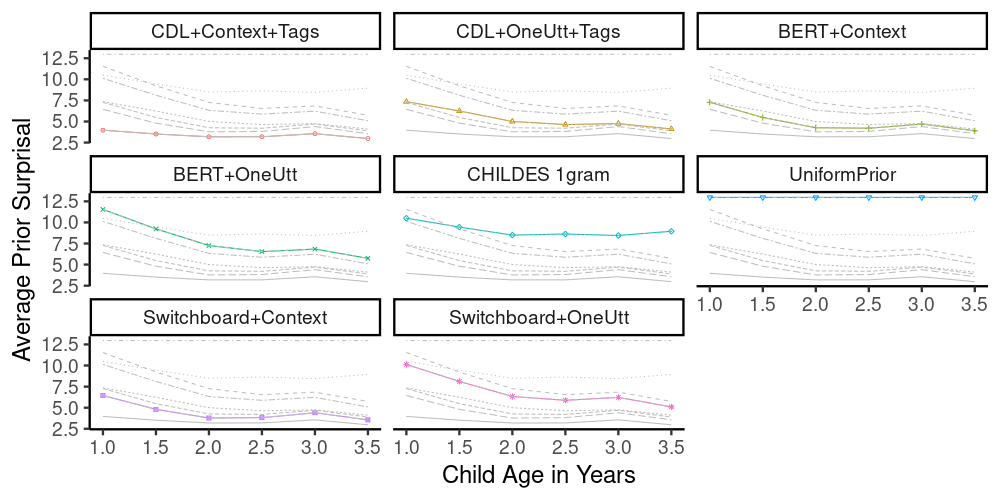

time: 724 ms (started: 2022-02-21 17:03:48 -08:00)


In [60]:
%%R -w 1000 -h 500

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none') + scale_shape_manual(values=1:nlevels(overview_mean_surprisal_by_age$model)
    ) + scale_color_discrete()

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 

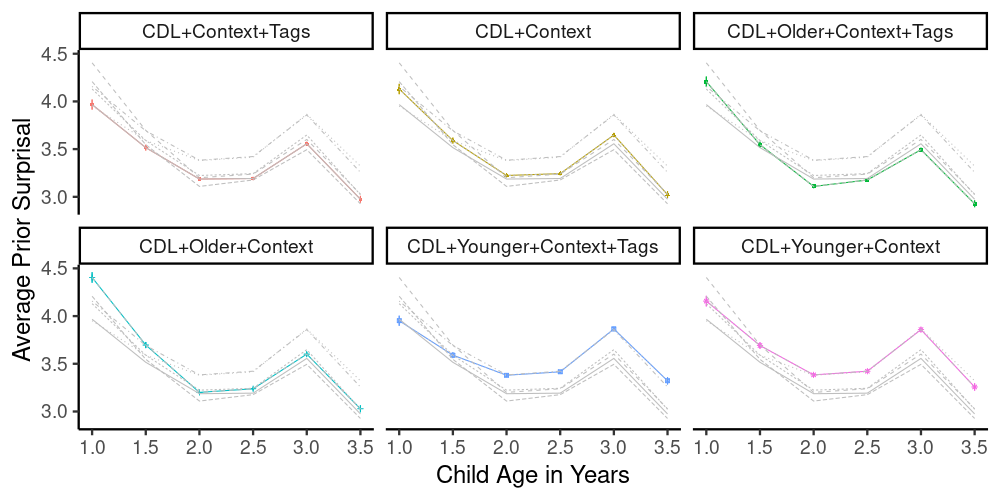

time: 451 ms (started: 2022-02-21 17:03:49 -08:00)


In [61]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')



## Posterior

In [62]:
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','likelihood','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
#%R print(mean_surprisal_by_age)

,age,model,likelihood,posterior_surprisal_mean,posterior_surprisal_sem
1,1.0,BERT+Context,Levenshtein Distance,4.345187,0.114305
2,1.0,BERT+Context,WFST,2.791358,0.089477
3,1.0,BERT+OneUtt,Levenshtein Distance,7.309036,0.149313
4,1.0,BERT+OneUtt,WFST,5.122672,0.124067
5,1.0,CDL+Context,Levenshtein Distance,2.359120,0.089852
...,...,...,...,...,...
212,3.5,Switchboard+Context,WFST,0.411890,0.029452
213,3.5,Switchboard+OneUtt,Levenshtein Distance,1.301500,0.058171
214,3.5,Switchboard+OneUtt,WFST,0.748000,0.039734
215,3.5,UniformPrior,Levenshtein Distance,3.800962,0.072356


time: 4.25 s (started: 2022-02-21 17:03:49 -08:00)


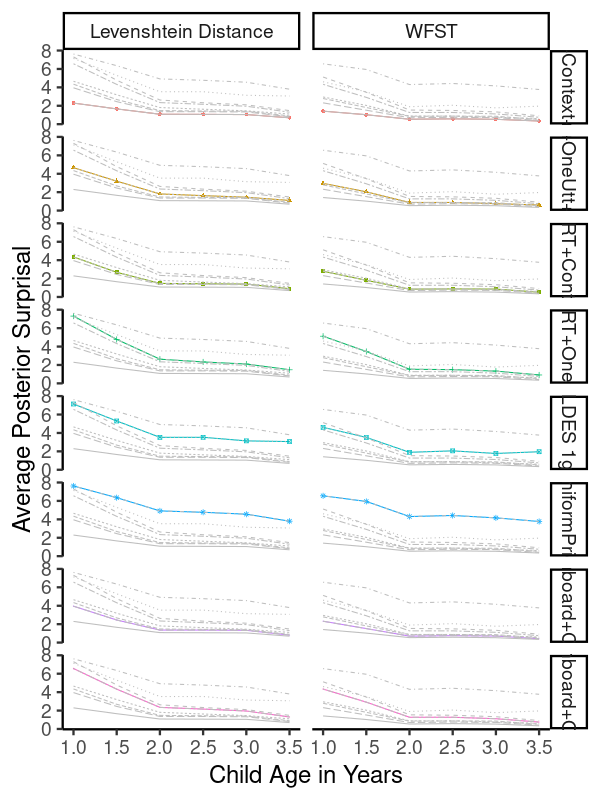

time: 750 ms (started: 2022-02-21 17:03:54 -08:00)


In [63]:
%%R -w 600 -h 800

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_grid(model~likelihood) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


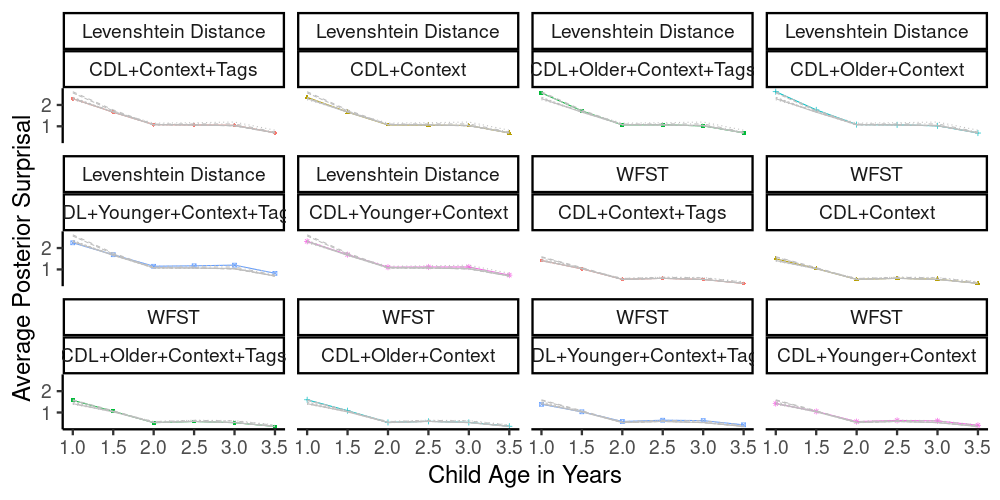

time: 815 ms (started: 2022-02-21 17:03:54 -08:00)


In [64]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(likelihood~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [65]:
%%R
unique(as.character(mean_surprisal_by_age$model))

 [1] "BERT+Context"             "BERT+OneUtt"             
 [3] "CDL+Context"              "CDL+Context+Tags"        
 [5] "CDL+Older+Context"        "CDL+Older+Context+Tags"  
 [7] "CDL+Older+OneUtt"         "CDL+Older+OneUtt+Tags"   
 [9] "CDL+OneUtt"               "CDL+OneUtt+Tags"         
[11] "CDL+Younger+Context"      "CDL+Younger+Context+Tags"
[13] "CDL+Younger+OneUtt"       "CDL+Younger+OneUtt+Tags" 
[15] "CHILDES 1gram"            "Switchboard+Context"     
[17] "Switchboard+OneUtt"       "UniformPrior"            
time: 34.5 ms (started: 2022-02-21 17:03:55 -08:00)


In [66]:
%%R
mean_surprisal_by_age$model_shortname = gsub('\\+Tags', '', mean_surprisal_by_age$model)

time: 5.26 ms (started: 2022-02-21 17:03:55 -08:00)


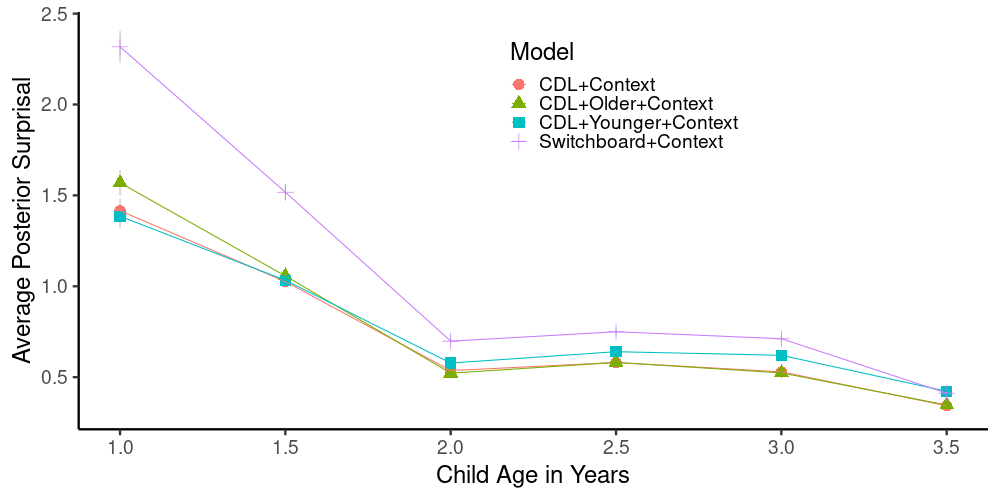

time: 426 ms (started: 2022-02-21 17:03:55 -08:00)


In [67]:
%%R -w 1000 -h 500

selected_models = c('CDL+Younger+Context+Tags', 'CDL+Older+Context+Tags', 'CDL+Context+Tags','Switchboard+Context')

p1 =  ggplot(subset(mean_surprisal_by_age, likelihood == 'WFST' &  model %in% selected_models)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + posterior_surprisal_sem), color="gray",  width=0) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model_shortname,
    shape = model_shortname), size=5) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model_shortname)
    )  + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') + theme(
    legend.position=c(.6, .8))  +  guides(shape = guide_legend(title = "Model"), color = guide_legend(title = "Model"))

ggsave('../../output/figures/posterior_surprisal_by_age.pdf', height=6, width=8)
p1

In [68]:
scores_across_time_short.drop_duplicates(subset=['bert_token_id']).set.value_counts()

success    45178
failure     6756
Name: set, dtype: int64

time: 100 ms (started: 2022-02-21 17:03:56 -08:00)


### Posterior Probability by Edit Distance

In [69]:
%%R
# have to do some data rotation to handle the fact that each observation needs both a Levenshtein distance and an edit dsitance
levdists = subset(successes_across_time, likelihood_type == "Levenshtein Distance" & model %in% overview_set)
dim(levdists)
wfsts = subset(successes_across_time, likelihood_type == "WFST" & model %in% overview_set)
dim(wfsts)

[1] 352000     15
time: 297 ms (started: 2022-02-21 17:03:56 -08:00)


In [70]:
%%R
unique(as.character(levdists$model))

[1] "BERT+OneUtt"         "BERT+Context"        "CDL+OneUtt+Tags"    
[4] "CDL+Context+Tags"    "Switchboard+OneUtt"  "Switchboard+Context"
[7] "UniformPrior"        "CHILDES 1gram"      
time: 26.2 ms (started: 2022-02-21 17:03:56 -08:00)


In [71]:
%%R
wfsts$wfst_distance = wfsts$edit_distance # copy wfst distance into its own column
wfsts$edit_distance = NULL
levdists$wfst_distance = 0 # leave this column unpopulated on levdists

time: 4.84 ms (started: 2022-02-21 17:03:56 -08:00)


In [72]:
%%R
print(dim(wfsts))
print(dim(levdists))

[1] 352000     15
[1] 352000     16
time: 15.3 ms (started: 2022-02-21 17:03:56 -08:00)


In [73]:
%%R
wfsts_merged = merge(wfsts, levdists[,c('bert_token_id','edit_distance')]) # this takes a while

time: 1min 41s (started: 2022-02-21 17:03:56 -08:00)


In [74]:
%%R
levdists[,c('bert_token_id','edit_distance')][1:10,]

     bert_token_id edit_distance
1891       1776009             3
1892       1029904             2
1893       1029905             2
1894        506615             1
1895        506616             2
1896        506620             1
1897        506621             0
1898        940389             0
1899        940390             0
1900        855679             3
time: 37.7 ms (started: 2022-02-21 17:05:38 -08:00)


In [75]:
%%R 
ed = rbind.fill(wfsts_merged, levdists) # this takes a while

time: 1min 45s (started: 2022-02-21 17:05:38 -08:00)


In [76]:
%%R
# confirm that edit distances are integers
unique(ed$edit_distance)

[1] 3 0 1 2 5 4 6 7 8
time: 70.3 ms (started: 2022-02-21 17:07:23 -08:00)


#### Statistical Test for Surprisal by Edit Distance

In [77]:
%%R
names(ed)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "likelihood_type"      
[13] "prior_rank"            "posterior_rank"        "wfst_distance"        
[16] "edit_distance"        
time: 31.6 ms (started: 2022-02-21 17:07:23 -08:00)


In [78]:
%%R
library(lme4)
names(ed)
lm1 = lm(posterior_probability ~ edit_distance , ed)
lm2 = lm(posterior_probability ~ edit_distance * model , ed)


print(BIC(lm1))
print(BIC(lm2))

# is a particular model actually lower? 

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




[1] 2639878
[1] 1611854
time: 4.85 s (started: 2022-02-21 17:07:23 -08:00)


In [79]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'likelihood_type', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, ed, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','likelihood_type','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal + surprisal_by_edit_distance$mean_posterior_surprisal_sem 
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal - surprisal_by_edit_distance$mean_posterior_surprisal_sem



time: 8.6 s (started: 2022-02-21 17:07:28 -08:00)


In [80]:
%%R
models_for_8_plots

[1] "CDL+Context"         "Switchboard+Context" "BERT+Context"       
[4] "CDL+OneUtt"          "Switchboard+OneUtt"  "BERT+OneUtt"        
[7] "CHILDES 1gram"       "UniformPrior"       
time: 16.7 ms (started: 2022-02-21 17:07:37 -08:00)


R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



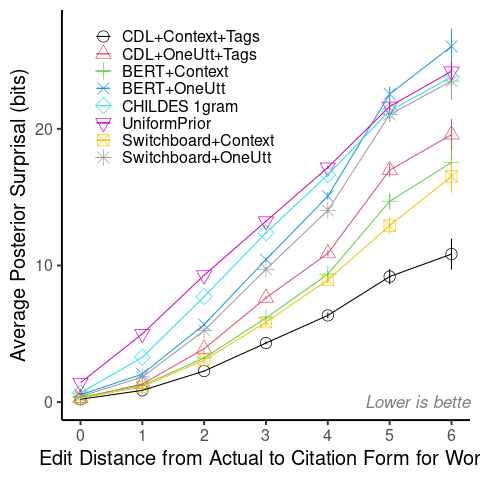

time: 318 ms (started: 2022-02-21 17:07:37 -08:00)


In [81]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type != 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width=0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
) + scale_shape_manual(values=1:nlevels(surprisal_by_edit_distance_for_plot$model)) + scale_color_manual(
        values=1:nlevels(surprisal_by_edit_distance_for_plot$model))

print(p1)

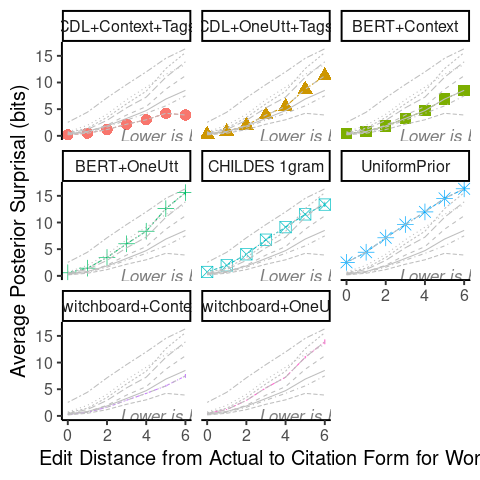

time: 588 ms (started: 2022-02-21 17:07:37 -08:00)


In [82]:
%%R
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model, linetype=likelihood_type)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')
print(p1)

#### Levenshtein Distance Plots

In [83]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior" & likelihood_type == 'Levenshtein Distance')[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance_lev = merge(subset(surprisal_by_edit_distance, likelihood_type == 'Levenshtein Distance'), unigram_prior)
surprisal_by_edit_distance_lev$multiplier = 2^( surprisal_by_edit_distance_lev$unigram_prior_prob -
    surprisal_by_edit_distance_lev$mean_posterior_surprisal)

head(surprisal_by_edit_distance_lev, n=10)


   edit_distance               model      likelihood_type
1              0        BERT+Context Levenshtein Distance
2              0         BERT+OneUtt Levenshtein Distance
3              0    CDL+Context+Tags Levenshtein Distance
4              0     CDL+OneUtt+Tags Levenshtein Distance
5              0       CHILDES 1gram Levenshtein Distance
6              0 Switchboard+Context Levenshtein Distance
7              0  Switchboard+OneUtt Levenshtein Distance
8              0        UniformPrior Levenshtein Distance
9              1        BERT+Context Levenshtein Distance
10             1         BERT+OneUtt Levenshtein Distance
   mean_posterior_surprisal mean_posterior_surprisal_sem      high       low
1                 0.3562092                  0.008921247 0.3651305 0.3472880
2                 0.5353647                  0.010170019 0.5455347 0.5251947
3                 0.2120225                  0.005978211 0.2180008 0.2060443
4                 0.2940632                  0.0064534

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



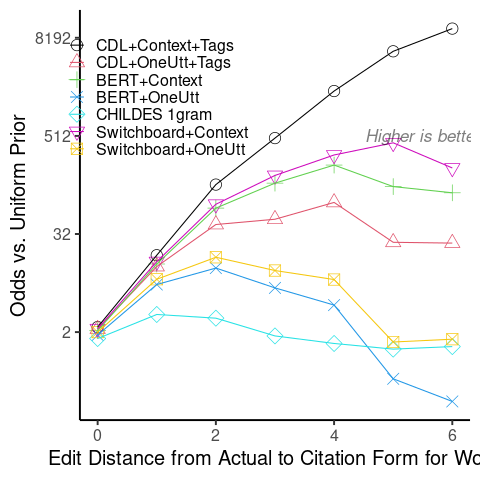

time: 306 ms (started: 2022-02-21 17:07:38 -08:00)


In [84]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance_lev, edit_distance <= 6 & model %in% overview_set 
& likelihood_type =='Levenshtein Distance' & model != 'UniformPrior')) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=512, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2'
) + scale_shape_manual(values = 1:8) + scale_color_manual(values = 1:8)    
print(p2)

#### WFST Plots

In [85]:
%%R
# make sure it uses the same colors
surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)
surprisal_by_edit_distance_for_plot$model_shortname= gsub('\\+Tags','',surprisal_by_edit_distance_for_plot$model)
surprisal_by_edit_distance_for_plot$model_shortname = factor(surprisal_by_edit_distance_for_plot$model_shortname, levels = models_for_8_plots)


time: 4.91 ms (started: 2022-02-21 17:07:38 -08:00)


R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'shape' is already present. Adding another scale for 'shape', which
will replace the existing scale.



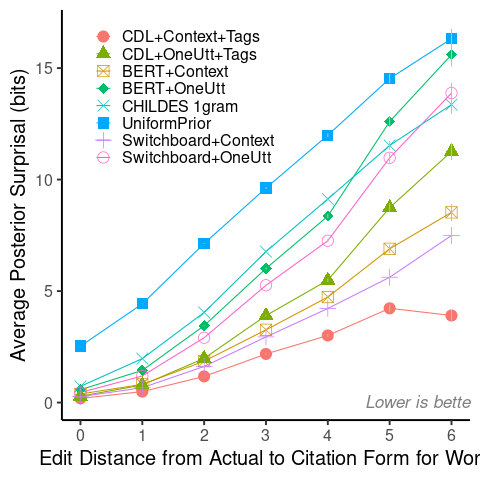

time: 535 ms (started: 2022-02-21 18:56:06 -08:00)


In [130]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, likelihood_type == 'WFST' & edit_distance <= 6)


surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot)  + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank(), legend.title = element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")  + scale_x_continuous(breaks=c(0:6), labels = c(0:6)
) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + scale_shape_manual(values=1:nlevels(surprisal_by_edit_distance_for_plot$model)) + scale_color_manual(
        values=1:nlevels(surprisal_by_edit_distance_for_plot$model)) + scale_color_manual(
        values=colors_for_8_plots) + scale_shape_manual(values = shapes_for_8_plots) + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high), color="gray", width=0)


ggsave('../../output/figures/surpsisal_by_edit_distance_wfst.pdf', height=6, width=8)    
print(p1)

### Proportion Agreeing with Annotator

In [87]:
%%R
proportion_retrieved = aggregate(prior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x < 5)})
proportion_retrieved

                      model      likelihood_type prior_rank
1          CDL+Context+Tags Levenshtein Distance  0.7608938
2               CDL+Context Levenshtein Distance  0.7584161
3           CDL+OneUtt+Tags Levenshtein Distance  0.6000045
4                CDL+OneUtt Levenshtein Distance  0.5986180
5              BERT+Context Levenshtein Distance  0.6526493
6               BERT+OneUtt Levenshtein Distance  0.4362740
7    CDL+Older+Context+Tags Levenshtein Distance  0.7625759
8         CDL+Older+Context Levenshtein Distance  0.7551656
9          CDL+Older+OneUtt Levenshtein Distance  0.5996863
10    CDL+Older+OneUtt+Tags Levenshtein Distance  0.6012547
11 CDL+Younger+Context+Tags Levenshtein Distance  0.7443002
12      CDL+Younger+Context Levenshtein Distance  0.7473007
13  CDL+Younger+OneUtt+Tags Levenshtein Distance  0.5729093
14       CDL+Younger+OneUtt Levenshtein Distance  0.5498602
15            CHILDES 1gram Levenshtein Distance  0.1587753
16             UniformPrior Levenshtein 

In [88]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + likelihood_type, successes_across_time, function(x){mean(x == 0)})
proportion_retrieved

                      model      likelihood_type posterior_rank
1          CDL+Context+Tags Levenshtein Distance      0.8208351
2               CDL+Context Levenshtein Distance      0.8228809
3           CDL+OneUtt+Tags Levenshtein Distance      0.7308890
4                CDL+OneUtt Levenshtein Distance      0.7261837
5              BERT+Context Levenshtein Distance      0.7601209
6               BERT+OneUtt Levenshtein Distance      0.6576955
7    CDL+Older+Context+Tags Levenshtein Distance      0.8198350
8         CDL+Older+Context Levenshtein Distance      0.8198577
9          CDL+Older+OneUtt Levenshtein Distance      0.7304571
10    CDL+Older+OneUtt+Tags Levenshtein Distance      0.7309572
11 CDL+Younger+Context+Tags Levenshtein Distance      0.8081740
12      CDL+Younger+Context Levenshtein Distance      0.8156752
13  CDL+Younger+OneUtt+Tags Levenshtein Distance      0.7054077
14       CDL+Younger+OneUtt Levenshtein Distance      0.7119314
15            CHILDES 1gram Levenshtein 

### Proportion Agreeing with Annotator Per Age

In [89]:
%%R
names(successes_across_time)

 [1] "posterior_probability" "posterior_entropy"     "prior_probability"    
 [4] "prior_entropy"         "kl_flat_to_prior"      "kl_flat_to_posterior" 
 [7] "model"                 "set"                   "age"                  
[10] "token"                 "bert_token_id"         "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
time: 24 ms (started: 2022-02-21 17:07:40 -08:00)


In [90]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model + age + likelihood_type, successes_across_time, function(x){mean(x == 0)})

time: 1.88 s (started: 2022-02-21 17:07:40 -08:00)


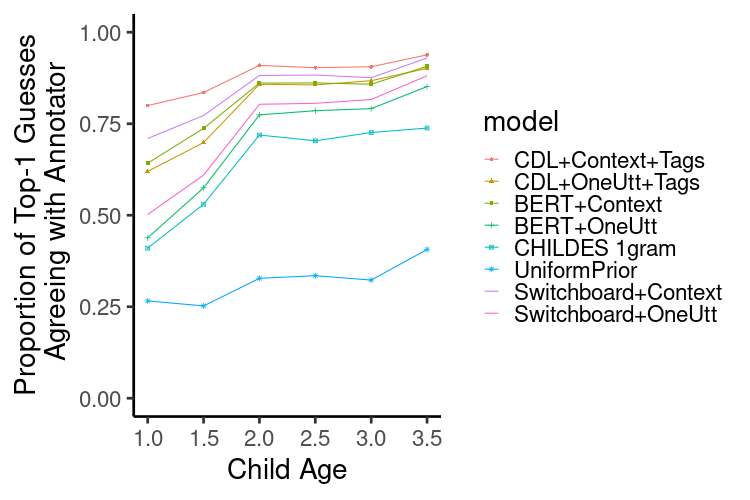

time: 216 ms (started: 2022-02-21 17:07:42 -08:00)


In [91]:
%%R -w 750 -h 500
ggplot(filter_model_subset(subset(proportion_retrieved, likelihood_type == 'WFST'), overview_set)) + geom_line(aes(x=age, y=posterior_rank, color=model)
) + geom_point(aes(x=age, y=posterior_rank, color=model, shape=model)) + coord_cartesian(ylim=c(0,1)) + xlab('Child Age') + ylab(
    'Proportion of Top-1 Guesses\n Agreeing with Annotator') + theme_classic(base_size=28) + theme(legend.background = element_blank())




### Posterior by Edit Distance by Likelihood 

In [92]:
from src.utils import load_splits
all_tokens_phono = load_splits.load_phono()




time: 6.65 s (started: 2022-02-21 17:07:42 -08:00)


In [93]:
all_tokens_phono.columns

Index(['token', 'utterance_id', 'gloss', 'transcript_id', 'utterance_order',
       'target_child_name', 'speaker_code', 'type', 'punct',
       'speaker_code_simple', 'gloss_with_punct', 'token_id', 'seq_utt_id',
       'actual_phonology', 'model_phonology', 'target_child_age',
       'bert_token_id', 'model_phonology_clean', 'actual_phonology_clean',
       'model_phonology_no_dia', 'actual_phonology_no_dia', 'cv_raw_actual',
       'cv_collapsed_actual', 'num_vowels_actual', 'cv_raw_model',
       'cv_collapsed_model', 'num_vowels_model', 'num_vowels', 'in_vocab',
       'success_token', 'yyy_token', 'partition', 'phase_sample', 'year',
       'phase_child_sample', 'phase_child_finetune',
       'phase_child_sample_n=2_type=success_name=Alex',
       'phase_child_sample_n=2_type=success_name=Ethan',
       'phase_child_sample_n=2_type=success_name=Lily',
       'phase_child_sample_n=2_type=success_name=Naima',
       'phase_child_sample_n=2_type=success_name=Violet',
       'phase_c

time: 3.26 ms (started: 2022-02-21 17:07:49 -08:00)


In [94]:
all_tokens_phono['citation_len'] = [len(x) for x in all_tokens_phono.model_phonology_no_dia]
all_tokens_phono['child_len'] = [len(x) for x in all_tokens_phono.actual_phonology_no_dia]
all_tokens_phono['phono_change'] = all_tokens_phono['child_len'] - all_tokens_phono['citation_len']
ipa_tokens = all_tokens_phono.dropna(subset=['actual_phonology_no_dia'])[['bert_token_id','phono_change']]
%R -i ipa_tokens

time: 39.8 s (started: 2022-02-21 17:07:49 -08:00)


In [95]:
%%R
ed_with_phono_change = merge(ed, ipa_tokens)

time: 1min 53s (started: 2022-02-21 17:08:29 -08:00)


In [96]:
%%R
names(ed_with_phono_change)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "likelihood_type"      
[13] "prior_rank"            "posterior_rank"        "wfst_distance"        
[16] "edit_distance"         "phono_change"         
time: 33.6 ms (started: 2022-02-21 17:10:22 -08:00)


In [119]:
%%R

#need the length of the adult string vs. the child string 

prob_by_edit_distance_likelihood = aggregate(posterior_probability ~ likelihood_type + phono_change + model, ed_with_phono_change, mean)

prob_by_edit_distance_likelihood_sem = aggregate(posterior_probability ~ likelihood_type + phono_change + model, ed_with_phono_change, sem)
names(prob_by_edit_distance_likelihood_sem) = c('likelihood_type', 'phono_change', 'model', 'sem')

prob_by_edit_distance_likelihood = merge(prob_by_edit_distance_likelihood, prob_by_edit_distance_likelihood_sem)
prob_by_edit_distance_likelihood$high = prob_by_edit_distance_likelihood$posterior_probability + prob_by_edit_distance_likelihood$sem
prob_by_edit_distance_likelihood$low = prob_by_edit_distance_likelihood$posterior_probability - prob_by_edit_distance_likelihood$sem


time: 4.45 s (started: 2022-02-21 17:27:03 -08:00)


In [121]:
%%R
prob_by_edit_distance_likelihood$likelihood_type = factor(prob_by_edit_distance_likelihood$likelihood_type, 
levels = c('WFST', 'Levenshtein Distance'))

time: 10.3 ms (started: 2022-02-21 17:27:17 -08:00)


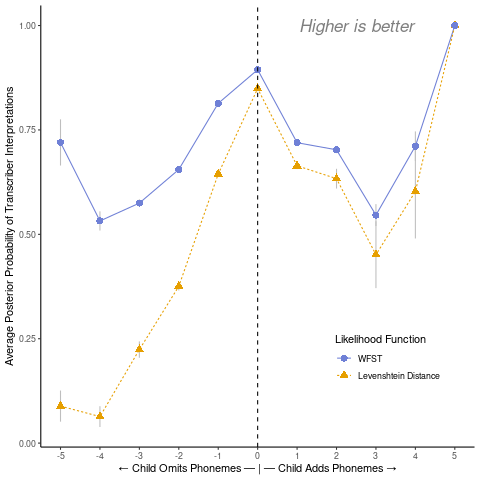

time: 536 ms (started: 2022-02-22 04:34:21 -08:00)


In [152]:
%%R
colors = 


p1 = ggplot(subset(prob_by_edit_distance_likelihood, model == "CDL+Context+Tags")) + geom_errorbar(
aes(x=phono_change, ymin = low, ymax=high), color='gray', width=0) + geom_line(aes(x=phono_change, y=posterior_probability,
    color = likelihood_type, linetype = likelihood_type )) + geom_point(aes(x=phono_change, y=posterior_probability,
    color = likelihood_type, shape=likelihood_type), size=3) + theme_classic() + ylab('Average Posterior Probability of Transcriber Interpretations') + xlab (
    '← Child Omits Phonemes — | — Child Adds Phonemes →') + geom_vline(xintercept=0, linetype='dashed'
) + scale_x_continuous(breaks=c(-5:5), labels = c(-5:5))  + scale_shape_discrete(name = "Likelihood Function") + scale_linetype_discrete(name = "Likelihood Function") + theme(legend.position = c(.8, .2)
) + annotate("text", label="Higher is better", 
    x=2.5, y=1, alpha=.5, size=6, fontface ="italic")  + scale_color_manual(values=c("#6f80d6", "#E69F00"), name = "Likelihood Function")

ggsave("../../output/figures/likelihood_function_by_change.png", width = 5, height=5)
print(p1)

# Child-Specific Analyses

In [101]:

all_tokens_phono_short = all_tokens_phono[['bert_token_id','target_child_name']]
%R -i all_tokens_phono_short

time: 1min 2s (started: 2022-02-21 17:10:27 -08:00)


In [102]:
%%R
successes_across_time_with_child_label = merge(successes_across_time, all_tokens_phono_short)

time: 1min 9s (started: 2022-02-21 17:11:29 -08:00)


In [103]:
%%R
names(successes_across_time_with_child_label)

 [1] "bert_token_id"         "posterior_probability" "posterior_entropy"    
 [4] "prior_probability"     "prior_entropy"         "kl_flat_to_prior"     
 [7] "kl_flat_to_posterior"  "model"                 "set"                  
[10] "age"                   "token"                 "edit_distance"        
[13] "likelihood_type"       "prior_rank"            "posterior_rank"       
[16] "target_child_name"    
time: 32.7 ms (started: 2022-02-21 17:12:38 -08:00)


In [104]:
%%R
posterior_entropy_by_child = aggregate(posterior_entropy ~ model + likelihood_type + target_child_name, successes_across_time_with_child_label, mean)
subset(posterior_entropy_by_child, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name posterior_entropy
19  CDL+Context+Tags            WFST              Alex         0.4850162
55  CDL+Context+Tags            WFST             Ethan         0.5900796
91  CDL+Context+Tags            WFST              Lily         0.2838924
127 CDL+Context+Tags            WFST             Naima         0.3600090
163 CDL+Context+Tags            WFST            Violet         0.3905320
199 CDL+Context+Tags            WFST           William         0.4711304
time: 1.23 s (started: 2022-02-21 17:12:38 -08:00)


In [105]:
%%R
proportion_retrieved = aggregate(prior_probability ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(-1 *log(x, base=2))})
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')

               model likelihood_type target_child_name prior_probability
19  CDL+Context+Tags            WFST              Alex          4.016616
55  CDL+Context+Tags            WFST             Ethan          3.340438
91  CDL+Context+Tags            WFST              Lily          3.009920
127 CDL+Context+Tags            WFST             Naima          3.197227
163 CDL+Context+Tags            WFST            Violet          3.203181
199 CDL+Context+Tags            WFST           William          3.449705
time: 1.38 s (started: 2022-02-21 17:12:39 -08:00)


In [106]:
%%R
proportion_retrieved = aggregate(posterior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')


               model likelihood_type target_child_name proportion_top_1
19  CDL+Context+Tags            WFST              Alex        0.8714394
55  CDL+Context+Tags            WFST             Ethan        0.8211613
91  CDL+Context+Tags            WFST              Lily        0.9293833
127 CDL+Context+Tags            WFST             Naima        0.9006317
163 CDL+Context+Tags            WFST            Violet        0.8918855
199 CDL+Context+Tags            WFST           William        0.8734289
time: 927 ms (started: 2022-02-21 17:12:41 -08:00)


In [107]:
%%R
proportion_retrieved = aggregate(prior_rank ~ model  + likelihood_type + target_child_name, successes_across_time_with_child_label, function(x){mean(x == 0)})
names(proportion_retrieved)[4] = 'proportion_top_1'
subset(proportion_retrieved, likelihood_type == 'WFST' & model == 'CDL+Context+Tags')



               model likelihood_type target_child_name proportion_top_1
19  CDL+Context+Tags            WFST              Alex        0.4766826
55  CDL+Context+Tags            WFST             Ethan        0.5801290
91  CDL+Context+Tags            WFST              Lily        0.5669935
127 CDL+Context+Tags            WFST             Naima        0.5809038
163 CDL+Context+Tags            WFST            Violet        0.5524012
199 CDL+Context+Tags            WFST           William        0.5423969
time: 1.03 s (started: 2022-02-21 17:12:42 -08:00)
